## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
29447,00007670_007.png,Emphysema|Fibrosis|Pneumothorax,7,7670,45,F,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00007670_007.png
69088,00017046_015.png,Pleural_Thickening,15,17046,63,M,PA,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017046_015.png
21862,00005793_004.png,Infiltration|Mass|Nodule,4,5793,22,M,AP,2500,2048,0.168,0.168,NaN,/data/images_003/images/00005793_004.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(13)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
11658,00003052_002.png,Atelectasis|Consolidation|Emphysema|Pneumothorax,2,3052,45,F,AP,2500,2048,0.171000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
62338,00015420_006.png,No Finding,6,15420,45,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41838,00010790_014.png,Infiltration,14,10790,56,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
58212,00014398_001.png,No Finding,1,14398,56,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12257,00003191_004.png,No Finding,4,3191,53,F,PA,2350,2917,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59170,00014637_003.png,Atelectasis|Infiltration,3,14637,60,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28843,00007526_036.png,No Finding,36,7526,66,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100625,00026713_004.png,No Finding,4,26713,62,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
94878,00024601_000.png,Hernia,0,24601,66,M,PA,2758,2530,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65787,00016240_000.png,Infiltration,0,16240,57,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['img_path'] = ImageDataGenerator(rescale=1. / 255.0,
                          horizontal_flip =True , 
                              vertical_flip =False , 
                              height_shift_range = 0.33, 
                              width_shift_range = 0.24, 
                              rotation_range = 20 , 
                              shear_range = 0.22 ,
                              zoom_range= 0.13
                        )


all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))
IMG_SIZE = (1, 224, 224, 1)

all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].astype(str)
#let's look at how a sample image looks like 

all_xray_df.sample(6)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path,pneumonia_class
89917,00022331_000.png,Infiltration,0,22331,30,M,PA,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
85702,00021133_003.png,No Finding,3,21133,48,M,PA,2898,2959,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
58476,00014459_001.png,No Finding,1,14459,17,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
103026,00027464_011.png,Consolidation|Infiltration,11,27464,34,F,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
102476,00027304_000.png,Pneumothorax,0,27304,59,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,<keras.preprocessing.image.ImageDataGenerator ...,0
7059,00001862_005.png,No Finding,5,1862,32,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0


## Create your training and testing data:

In [5]:
# def create_splits(train_data, val_data):
train_data, val_data = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds)) 
train_data = train_data.loc[p_inds + np_sample]

train_data['Pneumonia'].sum()/len(train_data)
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
p_inds = val_data[val_data.Pneumothorax==1].index.tolist()
np_inds = val_data[val_data.Pneumothorax==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]    

val_data['Pneumonia'].sum()/len(val_data)
    
train_data.sample(4)
  #  return train_data, val_data

# i should probably throw away some data now for balance


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path,pneumonia_class
104035,00027758_004.png,Atelectasis|Effusion|Pneumonia,4,27758,49,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,1
89501,00022215_015.png,Atelectasis|Infiltration,15,22215,53,F,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
3577,00000967_001.png,No Finding,1,967,22,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
61088,00015069_000.png,Infiltration|Pneumonia,0,15069,25,M,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,1


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

Found 2290 validated image filenames belonging to 2 classes.
Found 5285 validated image filenames belonging to 2 classes.


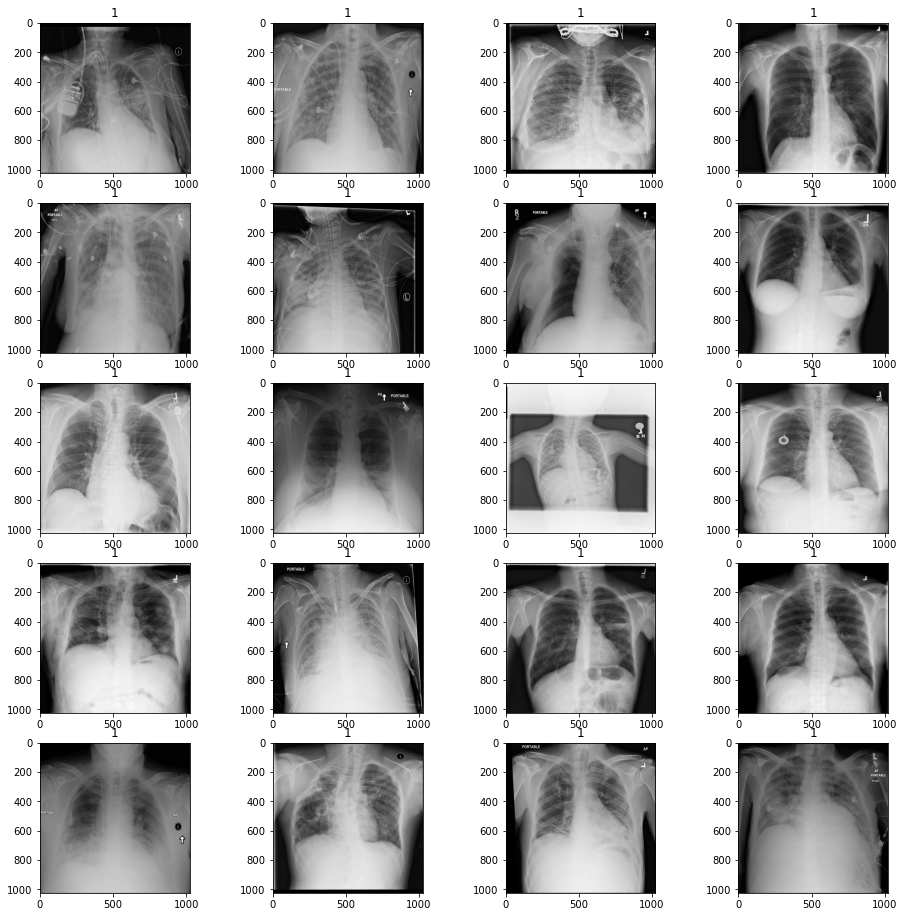

In [6]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                          horizontal_flip =True , 
                              vertical_flip =False , 
                              height_shift_range = 0.33, 
                              width_shift_range = 0.24, 
                              rotation_range = 20 , 
                              shear_range = 0.22 ,
                              zoom_range= 0.13
                        )

train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 80
                                         )

val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    
val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 80)


all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'True' if b else 'False')

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
#    return my_train_idg


# def make_train_gen(train_gen):
    
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#    train_gen = my_train_idg.flow_from_dataframe(dataframe='pneumonia_class', 
#                                          directory=None, 
#                                          x_col = 'path',
#                                          y_col = 'Image Index',
#                                          class_mode = 'binary',
#                                          target_size = IMG_SIZE, 
#                                          batch_size = 10) 
#    return train_gen
        

#def make_val_gen(val_gen):
#    

#    val_gen = flow_from_dataframe(dataframe = val_df, 
#                                              directory=None, 
 #                                             x_col = 'path',
  #                                            y_col = 'pneumonia_class',
   #                                           class_mode = 'binary',
    #                                          target_size = IMG_SIZE, 
     #                                         batch_size = 32) 
    #
#    return val_gen
from skimage import io

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_data.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_data.iloc[ind]['pneumonia_class'])
    ind=ind+1



In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:

valX, valY = val_gen.next()

ValueError: could not broadcast input array from shape (1,224,3) into shape (1,224,224,1,3)

In [ ]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [ ]:
# def load_pretrained_model(model, transfer_layer, vgg_model):
    
    
   # model = VGG16(include_top=True, weights='imagenet')
   # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
   # return vgg_model

model = VGG16(include_top=True, weights='imagenet')
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)   

In [ ]:
#def build_my_model(vargs):

from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

    
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))
             
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    #return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                            monitor= 'loss', 
                            verbose=1,                              save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_accuracy', 
                      min_delta = 0,
                      mode= 'max', 
                      baseline = '0.9855',
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model

# Todo

my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
optimizer = Adam(lr=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)



##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model = xray_class_my_model.best.hdf5
pred_Y = new_model.predict(valX, batch_size = 80, verbose = True)

In [ ]:
from sklearn import metrics
fpr, tpr = metrics.roc_curve(t_x, t_y, pos_label=2)

    
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve

    # Todo
    
    #return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)